In [2]:
import numpy as np
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/local/VANDERBILT/litz/github/MASILab/thoraxtools")
import func.vis.vis as vis
import glob
import re
from scipy import ndimage as ndi
import skimage.measure

In [3]:
def showslice(img, z, y, x, is_gray=False, clip_range=[]):
    clip_ax = img[z, :, :]
    clip_cor = img[:,y,:]
    clip_cor = np.flip(clip_cor, 0)
    clip_sag = img[:,:,x]
    clip_sag = np.flip(clip_sag, 0)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    # fig = plt.figure(1)
    f, ax = plt.subplots(1, 3, figsize=(15, 15))
    if is_gray:
        ax[0].imshow(clip_ax, interpolation='nearest', cmap='gray', vmin=vmin, vmax=vmax)
        ax[1].imshow(clip_cor, interpolation='nearest', cmap='gray', vmin=vmin, vmax=vmax)
        sag = ax[2].imshow(clip_sag, interpolation='nearest', cmap='gray', vmin=vmin, vmax=vmax)
        
    else:
        ax[0].imshow(clip_ax, interpolation='nearest', vmin=vmin, vmax=vmax)
        ax[1].imshow(clip_cor, interpolation='nearest', vmin=vmin, vmax=vmax)
        sag = ax[2].imshow(clip_sag, interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(sag, ax=ax[2], fraction=0.046, pad=0.04)

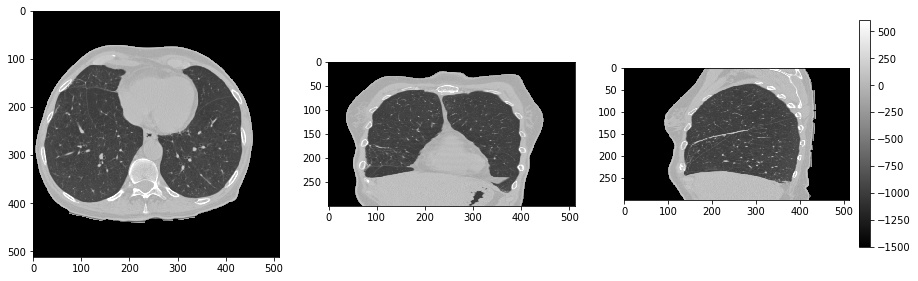

In [6]:
label_dir = "/home/local/VANDERBILT/litz/data/luna16/automatic_pulmonary_lobe_segmentation_using_deep_learning/annotations"
# file_name = os.listdir(annotation_dir)[0]

label_name= "1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059_LobeSegmentation.nrrd"
label_path = os.path.join(label_dir, label_name)
1
# raw file
raw_dir = "/home/local/VANDERBILT/litz/data/luna16/preproc_train/"
raw_name = "1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd"
raw_path = os.path.join(raw_dir, raw_name)

# label_dir = "/home/local/VANDERBILT/litz/data/luna16/automatic_pulmonary_lobe_segmentation_using_deep_learning/annotations"
# # file_name = os.listdir(annotation_dir)[0]

# label_name= "1.3.6.1.4.1.14519.5.2.1.6279.6001.119304665257760307862874140576_LobeSegmentation.nrrd"
# label_path = os.path.join(label_dir, label_name)
# 1
# # raw file
# raw_dir = "/home/local/VANDERBILT/litz/data/luna16/preproc_train/"
# raw_name = "1.3.6.1.4.1.14519.5.2.1.6279.6001.119304665257760307862874140576.mhd"
# raw_path = os.path.join(raw_dir, raw_name)

image_sitk = sitk.ReadImage(raw_path)
image_np = sitk.GetArrayFromImage(image_sitk)
showslice(image_np, 90,150,90, is_gray=True, clip_range=[-1500, 600])

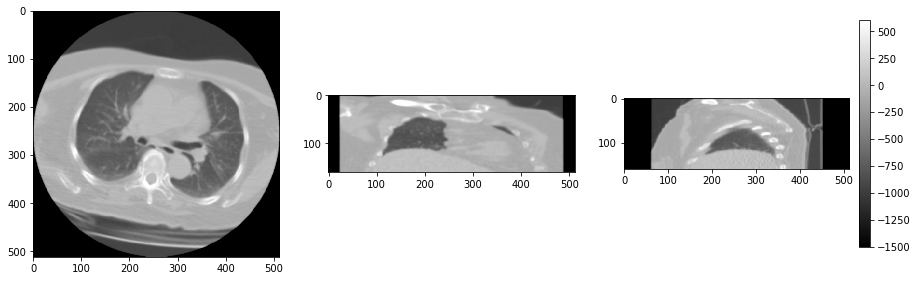

In [111]:
image_blur = ndi.gaussian_filter(image_np, sigma=1.5)
showslice(image_blur, 90, 150,90, is_gray=True, clip_range=[-1500, 600])

22474216 of 42205184 voxels masked.


/tmp/ipykernel_3217214/4073094296.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  struct = np.ones((3, 3, 3), dtype=np.bool)


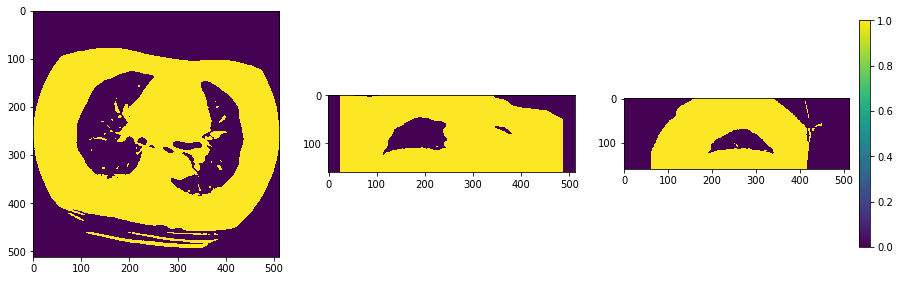

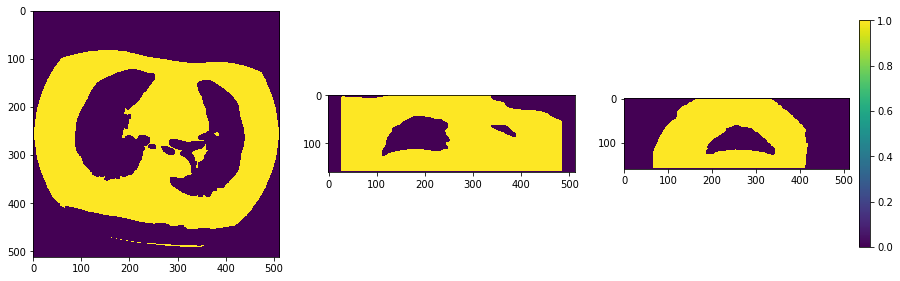

In [130]:
"""
Adapted from https://github.com/MASILab/thorax_level_BCA/blob/0ff54db11395a28b62d91132be0df49e4927a3b5/Utils/utils.py#L577
handles sitk images
"""

rBody = 2

BODY = (image_blur >= -500)  # & (I<=win_max)
print(f'{np.sum(BODY)} of {np.size(BODY)} voxels masked.')
if np.sum(BODY) == 0:
    raise ValueError('BODY could not be extracted!')
showslice(BODY, 90, 150,90)
# Find largest connected component in 3D
struct = np.ones((3, 3, 3), dtype=np.bool)
BODY = ndi.binary_erosion(BODY, structure=struct, iterations=rBody)
showslice(BODY, 90, 150,90)

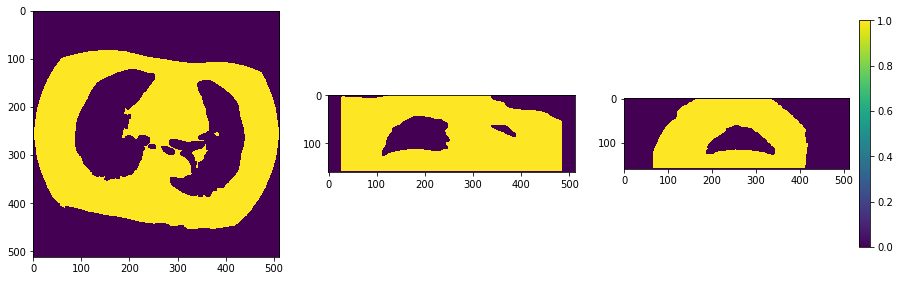

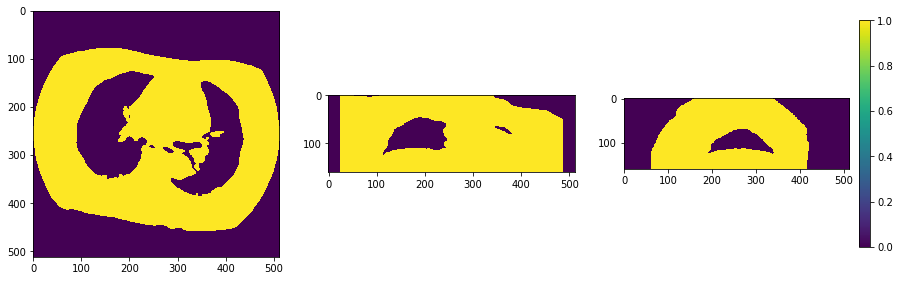

In [131]:
BODY_labels = skimage.measure.label(np.asarray(BODY, dtype=int))

props = skimage.measure.regionprops(BODY_labels)
areas = []
for prop in props:
    areas.append(prop.area)
showslice(BODY_labels == (np.argmax(areas) + 1), 90, 150,90)
BODY = ndi.binary_dilation(BODY_labels == (np.argmax(areas) + 1), structure=struct, iterations=2)
showslice(BODY,90,150,90)


In [132]:
for z in range(0, BODY.shape[2]):
    BODY[:, :, z] = ndi.binary_fill_holes(BODY[:, :, z])
for y in range(0, BODY.shape[0]):
    BODY[:, y, :] = ndi.binary_fill_holes(BODY[:, y, :])
for x in range(0, BODY.shape[0]):
    BODY[x, :, :] = ndi.binary_fill_holes(BODY[x, :, :])
masked = np.where(BODY==0, -1500, image_np)

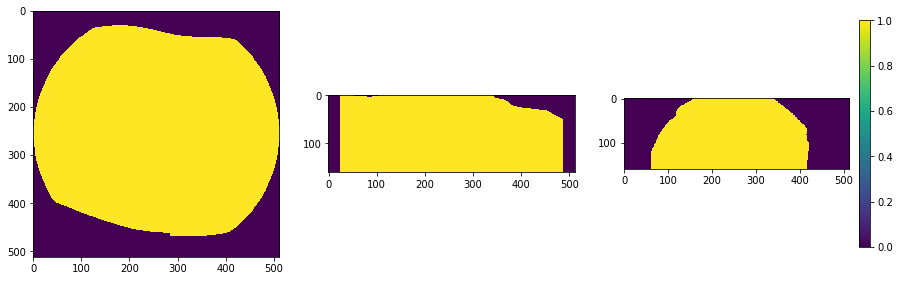

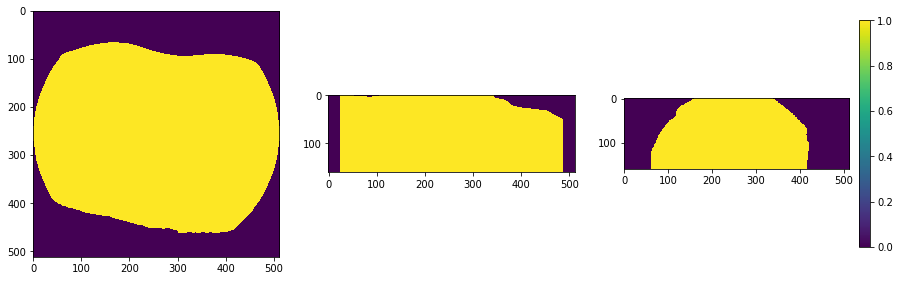

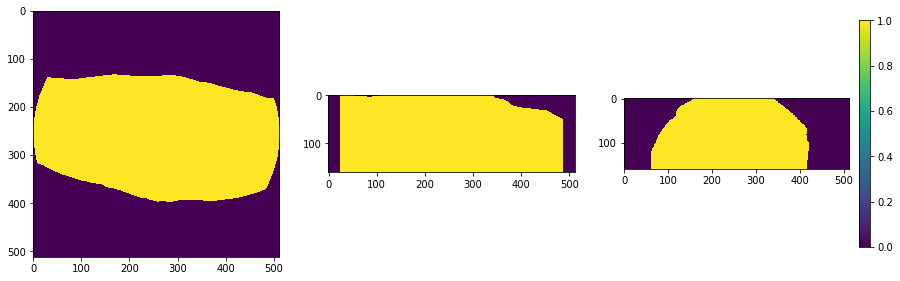

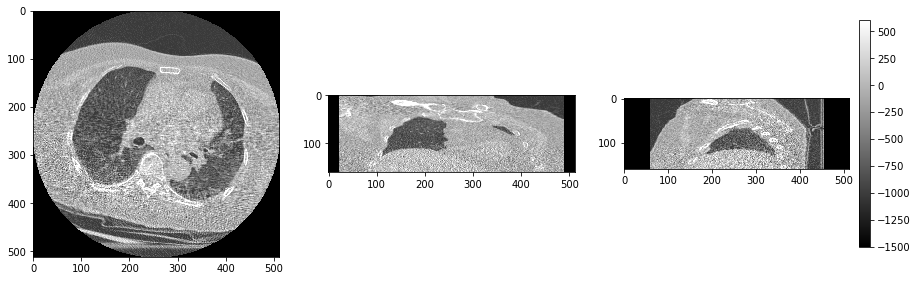

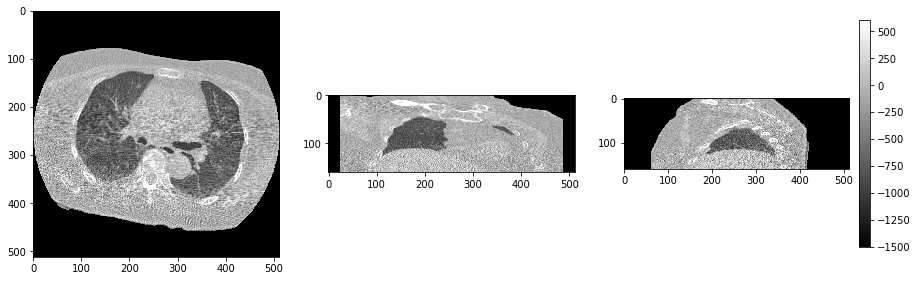

In [133]:
showslice(BODY,20,150,90)
showslice(BODY,80,150,90)
showslice(BODY,150,150,90)
showslice(image_np, 80,150,90, is_gray=True, clip_range=[-1500, 600])
showslice(masked, 90, 150,90, is_gray=True, clip_range=[-1500, 600])
# new_image = sitk.GetImageFromArray(BODY.astype(np.int8))
# new_image.CopyInformation(image_sitk)
# sitk.WriteImage(new_image, out_mask)
# # new_image = nib.Nifti1Image(BODY.astype(np.int8), header=image_nb.header, affine=image_nb.affine)
# # nib.save(new_image, out_mask)
# print(f'Generated body_mask segs in Abwall {out_mask}')